<a href="https://colab.research.google.com/github/hamuim/Patern-idea-TensorFlow/blob/main/HWSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/hamuim/Patern-idea-TensorFlow

Cloning into 'Patern-idea-TensorFlow'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (26/26), 13.41 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
import sys
sys.path.append("Patern-idea-TensorFlow")

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

In [ ]:
import matplotlib.pyplot as plt
import rn10
import ut
import time

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
AUTO = tf.data.AUTOTUNE

def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(scale, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)

class HWSHModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.055):
        super(HWSHModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)

        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)

        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

In [ ]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

In [ ]:
with strategy.scope():
    model = HWSHModel(ut.get_training_model())

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=100)

Epoch 1/100
391/391 [==============================] - 89s 159ms/step - loss: 2.2748 - accuracy: 0.1519 - val_loss: 1.8707 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 59s 151ms/step - loss: 1.8695 - accuracy: 0.2714 - val_loss: 1.6442 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 59s 152ms/step - loss: 1.6991 - accuracy: 0.3470 - val_loss: 1.4594 - val_accuracy: 0.4495 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 59s 152ms/step - loss: 1.5382 - accuracy: 0.4134 - val_loss: 1.3068 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 60s 152ms/step - loss: 1.4236 - accuracy: 0.4587 - val_loss: 1.2192 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 59s 152ms/step - loss: 1.3124 - accuracy: 0.5027 - val_loss: 1.0795 - val_accuracy: 0.6146 - lr: 0.0010
Epoch 7/100
391/391 [=========================

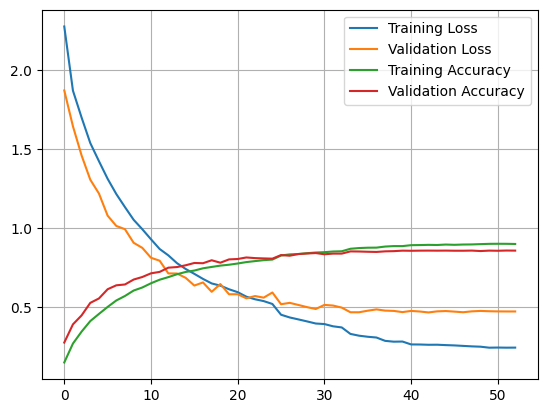

In [ ]:
ut.plot_history(history)

In [ ]:
with strategy.scope():
    model = ut.get_training_model()

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
391/391 [==============================] - 48s 82ms/step - loss: 1.6485 - accuracy: 0.3926 - val_loss: 1.7177 - val_accuracy: 0.4104 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 32s 81ms/step - loss: 1.2380 - accuracy: 0.5559 - val_loss: 1.2553 - val_accuracy: 0.5674 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 31s 79ms/step - loss: 1.0310 - accuracy: 0.6331 - val_loss: 1.0105 - val_accuracy: 0.6524 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 31s 80ms/step - loss: 0.8801 - accuracy: 0.6951 - val_loss: 0.9609 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 32s 81ms/step - loss: 0.7771 - accuracy: 0.7294 - val_loss: 0.7521 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 31s 79ms/step - loss: 0.7086 - accuracy: 0.7546 - val_loss: 0.9790 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 7/100
391/391 [==============================]

KeyboardInterrupt: ignored

In [ ]:
ut.plot_history(history)